Aqui será utilizada uma Deep Learninig LSTM para estimação de valores a frente para a o Bitcoin (BTC).

# Carregando os dados via KanggleHub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bitcoin-historical-data' dataset.
Path to dataset files: /kaggle/input/bitcoin-historical-data


In [ ]:
import os
os.chdir("/kaggle/input/bitcoin-historical-data")

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.layers import Conv1D, MaxPooling1D

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
import pandas as pd
df = pd.read_csv(path+'/btcusd_1-min_data.csv')


# Funções auxiliares

In [ ]:
#desenha gráfico com os dados em data e titulo em title
def plot(data, title: str, fig_size=(12,6)):
    plt.figure(figsize=fig_size)
    plt.title(title)
    plt.plot(data)
    plt.show()

In [ ]:
#desenha o gráfico com duas séries temporais
def plot_compare(x, y1, y2, color1: str, color2: str, label1: str, label2: str,
                 title: str, xlabel: str, ylabel: str):
    plt.figure()
    plt.plot(x, y1, color=color1, label=label1)
    plt.plot(x, y2, color=color2, label=label2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# Cria a sequencia de dados para prever o próximo valor baseado em seq_length
# create_sequence para prever o próximo valor
def create_sequence(data, seq_length):
    xlist = []
    ylist = []
    for i in range(len(data)-seq_length):
        seq = data[i:i+seq_length]
        xlist.append(seq)
        ylist.append(data[i+seq_length])

    x_arr = np.array(xlist)
    y_arr = np.array(ylist)
    return x_arr, y_arr

In [ ]:

def avaliar_modelo(y_real, y_previsto):
    # Garante que são arrays numpy para cálculos
    y_real = np.array(y_real)
    y_previsto = np.array(y_previsto)

    # 1. Métricas de Regressão
    rmse = np.sqrt(mean_squared_error(y_real, y_previsto))
    mae = mean_absolute_error(y_real, y_previsto)

    # MAPE
    mape = np.mean(np.abs((y_real - y_previsto) / (y_real + 1e-10))) * 100

    r2 = r2_score(y_real, y_previsto)


    print(f"--- Relatório de Performance ---")
    print(f"RMSE (Erro Quadrático): {rmse:.4f}")
    print(f"MAE (Erro Médio):       {mae:.4f}")
    print(f"MAPE (Erro %):          {mape:.2f}%")
    print(f"R² (Explicação da Var): {r2:.4f}")

    return rmse, mae, mape


# Análise dos dados

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [ ]:
#verifica se há dados faltantes e se o tipo dos dados está correto
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7322077 entries, 0 to 7322076
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 335.2 MB


In [ ]:
df.describe()

,Timestamp,Open,High,Low,Close,Volume
count,7.322077e+06,7.322077e+06,7.322077e+06,7.322077e+06,7.322077e+06,7.322077e+06
mean,1.545078e+09,2.128993e+04,2.129758e+04,2.128207e+04,2.128993e+04,5.127277e+00
std,1.268280e+08,2.995796e+04,2.996613e+04,2.994966e+04,2.995796e+04,2.206135e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.435243e+09,4.432300e+02,4.434100e+02,4.430100e+02,4.432300e+02,1.965912e-02
50%,1.545074e+09,7.288360e+03,7.292490e+03,7.284040e+03,7.288420e+03,4.487087e-01
75%,1.654905e+09,3.073300e+04,3.074323e+04,3.072200e+04,3.073300e+04,2.898410e+00
max,1.764806e+09,1.262020e+05,1.262720e+05,1.261580e+05,1.262020e+05,5.853852e+03


# Pré-processamento dos dados

In [ ]:
from datetime import datetime

df['Timestamp']=pd.to_datetime(df['Timestamp'],unit='s',dayfirst=True)
df.head()
df.info()

In [ ]:
# 1. Define a data como índice
df.set_index('Timestamp', inplace=True)

# 2. Garante que está ordenado cronologicamente (essencial para gráficos e backtests)
df.sort_index(inplace=True)

# Verifique o resultado
df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [ ]:
# Agrupa os dados por Dia ('D') tirando a média ou pegando o último preço
# '1h' para hora, 'D' para dia.
df= df.resample('D').last()

In [ ]:
#mostra todo o dataset do ativo escolhido
display(df)

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.84,4.84,4.84,4.84,0.000000
2012-01-02,5.00,5.00,5.00,5.00,0.000000
2012-01-03,5.29,5.29,5.29,5.29,0.000000
2012-01-04,5.57,5.57,5.57,5.57,0.000000
2012-01-05,6.42,6.42,6.42,6.42,0.000000
...,...,...,...,...,...
2025-11-29,90831.00,90832.00,90831.00,90832.00,0.025139
2025-11-30,90363.00,90386.00,90362.00,90382.00,0.410369
2025-12-01,86331.00,86332.00,86291.00,86291.00,1.193367


## Visualização dos dados

In [ ]:
#desenha o gráfico do ativo selecionado com o preço de fechamento ("close")

import plotly.express as px
fig = px.line(df, y=["Close"])
fig.update_layout(title=f'Preço diário do btc')
fig.show()

In [ ]:
# cria uma média móvel de 12 períodos com os preços de fechamento (close)
df['MA12'] = df['Close'].rolling(12).mean()
# desenha os dados e a média móvel
import plotly.express as px
fig = px.line(df, y=["Close", "MA12"], template = 'plotly_dark')
fig.update_layout(title='Preço diário do ativo BTC por mês')
fig.show()

In [ ]:
# faz uma cópia do dataset atual (df) em df2
df2=df.copy()
# Obtém a lista de todas as colunas no DataFrame
todas_colunas = list(df.columns)

# Obtém a lista de colunas com exceção da coluna "Close" que é o preço de fechamento da ação
colunas_a_remover = [coluna for coluna in todas_colunas if coluna != 'Close']

#elimina todas as colunas exceto "Close" que é o preço de fechamento (Close)
df2 = df2.drop(columns=colunas_a_remover)

display(df2)

,Close
Timestamp,
2012-01-01,4.84
2012-01-02,5.00
2012-01-03,5.29
2012-01-04,5.57
2012-01-05,6.42
...,...
2025-11-29,90832.00
2025-11-30,90382.00
2025-12-01,86291.00


In [ ]:

seq_length = 10
date = df2.index
dataset = np.array(df2)
#cria a sequencia de dados do dataset de tamanho seq_length
features, label = create_sequence(dataset, seq_length)
print(features.shape)
print(label.shape)
# print(date)


(5076, 10, 1)
(5076, 1)
DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2025-11-24', '2025-11-25', '2025-11-26', '2025-11-27',
               '2025-11-28', '2025-11-29', '2025-11-30', '2025-12-01',
               '2025-12-02', '2025-12-03'],
              dtype='datetime64[ns]', name='Timestamp', length=5086, freq='D')


### Cria um novo dataframe para para unir o features + label

In [ ]:
# cria o dataframe dataset_df conforme descrito na célula de texto acima
features_df = np.squeeze(features, axis=-1)
features_df = pd.DataFrame(features_df)
label_df = pd.DataFrame(label)
label_df.columns = ['Label']
dataset_df = pd.concat([features_df, label_df], axis=1)
dataset_df

,0,1,2,3,4,5,6,7,8,9,Label
0,4.84,5.00,5.29,5.57,6.42,6.40,6.80,6.90,6.48,7.10,7.00
1,5.00,5.29,5.57,6.42,6.40,6.80,6.90,6.48,7.10,7.00,6.51
2,5.29,5.57,6.42,6.40,6.80,6.90,6.48,7.10,7.00,6.51,6.90
3,5.57,6.42,6.40,6.80,6.90,6.48,7.10,7.00,6.51,6.90,6.40
4,6.42,6.40,6.80,6.90,6.48,7.10,7.00,6.51,6.90,6.40,7.15
...,...,...,...,...,...,...,...,...,...,...,...
5071,91474.00,86527.00,85060.00,84679.00,86803.00,88277.00,87331.00,90477.00,91325.00,90913.00,90832.00
5072,86527.00,85060.00,84679.00,86803.00,88277.00,87331.00,90477.00,91325.00,90913.00,90832.00,90382.00
5073,85060.00,84679.00,86803.00,88277.00,87331.00,90477.00,91325.00,90913.00,90832.00,90382.00,86291.00
5074,84679.00,86803.00,88277.00,87331.00,90477.00,91325.00,90913.00,90832.00,90382.00,86291.00,91300.00


## Normalização dos dados com MinMax

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Normaliza os dados na escala de 0 a 1
rescale = MinMaxScaler(feature_range=(0,1))
norm = rescale.fit_transform(df2)


### Divisão dados de treino e teste

In [ ]:
# Divide os dados em treinamento e teste
train_perc=0.8 #percentual de dados de treinamento
test_perc=1-train_perc #percentual de dados de teste

#calcula a quantidade de dados de treinamento e teste
tam_train=(int)(len(features)*train_perc)
tam_test=len(features)-tam_train

#Cria entrada e saida a partir dos dados normalizados com tamanho seq_length
x, y = create_sequence(norm, seq_length)
#divide os dados (x,y) em treinamento e teste
x_train, y_train = x[:tam_train], y[:tam_train]
#x_test, y_test = x_train[-tam_test:], label[-tam_test:]
x_test, y_test = x[-tam_test:], y[-tam_test:]

In [ ]:
#vendo as dimensões dos dados de treinamento e teste
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(f"seq_length={seq_length}")

(4060, 10, 1)
(4060, 1)
(1016, 10, 1)
(1016, 1)
seq_length=10


# Especificação e treinamento do Modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

### Primeiro modelo proposto

In [ ]:
# Especificação do modelo da Deep Learning LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1),activation='relu'))
model.add(LSTM(25, return_sequences=False,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(optimizer=Adam(),
              loss='mean_squared_error')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,271 (71.37 KB)

 Trainable params: 18,271 (71.37 KB)

 Non-trainable params: 0 (0.00 B)

### Segundo modelo proposto

In [ ]:
# Especificação do modelo da Deep Learning LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1),activation='tanh'))
model.add(LSTM(25, return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(15, return_sequences=False,activation='tanh'))
model.add(Dense(10,activation='tanh'))
model.add(Dense(1,activation='linear'))
model.compile(optimizer=Adam(),
              loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 10, 25)         │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 15)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,631 (80.59 KB)

 Trainable params: 20,631 (80.59 KB)

 Non-trainable params: 0 (0.00 B)

### Treinamento

In [ ]:

import keras
#earling stop
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, min_delta=0.001,restore_best_weights=True)
#salva o melhor modelo durante a validação com melhor accuracy no arquivo best_model.h5
mc = keras.callbacks.ModelCheckpoint('/content/best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(x_train,
                    y_train,
                    batch_size=1,  #1, #o tamanho do batch é 1 para usar cada linha com 5 dados para prever a próxima
                    epochs=100,
                    validation_split=0.2,
                    verbose=1, callbacks=[es, mc])

Epoch 1/100
3245/3248 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1310e-04
Epoch 1: val_loss improved from inf to 0.01110, saving model to /content/best_model.h5


3248/3248 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 1.1304e-04 - val_loss: 0.0111
Epoch 2/100
3242/3248 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0973e-05
Epoch 2: val_loss improved from 0.01110 to 0.00074, saving model to /content/best_model.h5


3248/3248 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 5.0967e-05 - val_loss: 7.3839e-04
Epoch 3/100
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3198e-05
Epoch 3: val_loss did not improve from 0.00074
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 3.3198e-05 - val_loss: 0.0035
Epoch 4/100
3244/3248 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7699e-05
Epoch 4: val_loss did not improve from 0.00074
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 2.7699e-05 - val_loss: 0.0036
Epoch 5/100
3247/3248 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3144e-05
Epoch 5: val_loss did not improve from 0.00074
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 2.3143e-05 - val_loss: 0.0095
Epoch 6/100
3247/3248 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0062e-05
Epoch 6: val_loss did not improve from 0.00074
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 2.0061e-05 - val_loss: 0.0025
Epoch 7/100
3246/3248 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5334e-05
Epoch 7: val_loss did not im

In [ ]:
from keras.models import load_model
model = load_model('/content/best_model.h5')

### Avaliação do Modelo

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

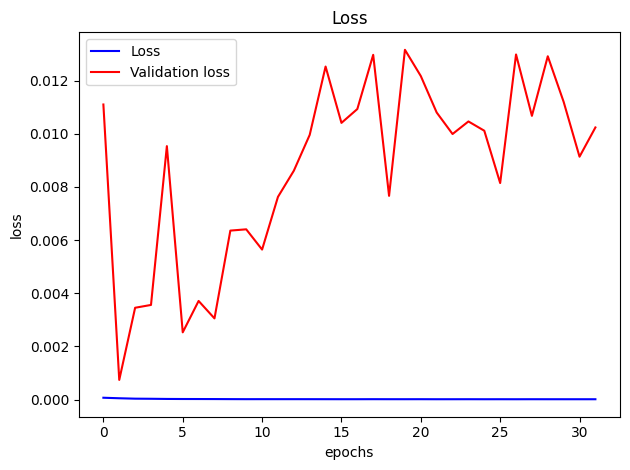

In [ ]:
# Plot loss graph

hist = history.history
hist_df = pd.DataFrame(hist)
plot_compare(range(len(hist_df)), hist_df['loss'], hist_df['val_loss'],
             color1='blue', color2='red', label1='Loss', label2='Validation loss',
             title='Loss', xlabel='epochs', ylabel='loss')

In [ ]:
# Mostra a avaliação do modelo nos dados de teste - neste caso, quanto mais próximo de zero melhor!!!
test=model.evaluate(x_test,y_test)
print(test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040
0.01538082119077444


In [ ]:
# Realizando avaliação com os dados de teste

y_pred = model.predict(x_test)

# Volta os dados normalizados para o valor original
y_pred = rescale.inverse_transform(y_pred)
y_test_denormalized = rescale.inverse_transform(y_test) # Denormalize y_test as well


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
avaliar_modelo(y_test_denormalized, y_pred)

--- Relatório de Performance ---
RMSE (Erro Quadrático): 15468.1539
MAE (Erro Médio):       10881.9711
MAPE (Erro %):          13.25%
R² (Explicação da Var): 0.7546


(np.float64(15468.153948363286),
 10881.971072219489,
 np.float64(13.25115134147028))

### Desenhando os dados de teste com o previsto/estimado

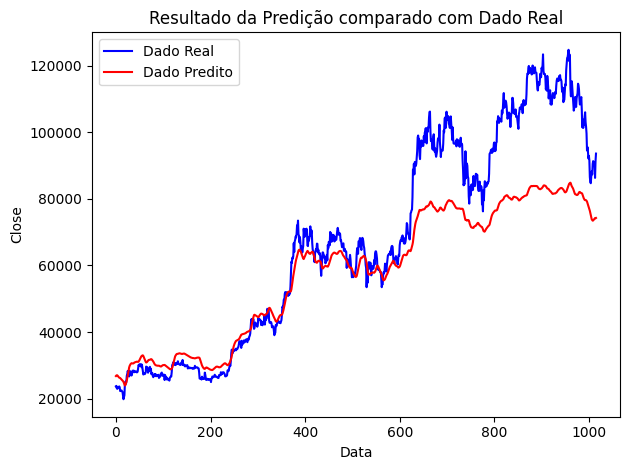

In [ ]:
y_test2 = rescale.inverse_transform(y_test)

plot_compare(range(len(y_test)) ,y_test2, y_pred, 'blue', 'red', 'Dado Real', 'Dado Predito',
              'Resultado da Predição comparado com Dado Real', 'Data', 'Close')

